<a href="https://colab.research.google.com/github/jwhan1129/Basic-Machine-learning-Codes/blob/master/BiS800_project3_RNNmodel_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Download dataset

In [1]:
!git clone https://github.com/alexarnimueller/LSTM_peptides

Cloning into 'LSTM_peptides'...
remote: Enumerating objects: 247, done.
remote: Total 247 (delta 0), reused 0 (delta 0), pack-reused 247
Receiving objects: 100% (247/247), 254.58 KiB | 838.00 KiB/s, done.
Resolving deltas: 100% (141/141), done.


In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
import time
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
import sys
import random
import scipy

In [0]:
f = open("/content/LSTM_peptides/training_sequences_noC.csv", 'r')
text = f.readlines()
f.close()

In [0]:
text_temp = []
for item in text:
  while len(item) < 49:
    item = item + '\n'
  text_temp.append(item)

text = list(itertools.chain.from_iterable(text_temp))

In [0]:
f = open("/content/LSTM_peptides/training_sequences_noC.csv", 'r')
text = f.read()
f.close()

In [0]:
vocab = [item for item in text]

In [7]:
vocab = sorted(set(vocab))
print ('고유 문자수 {}개'.format(len(vocab)))

고유 문자수 20개


In [8]:
vocab

['\n',
 'A',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [0]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [0]:
# 단일 입력에 대해 원하는 문장의 최대 길이
seq_length = 100
examples_per_epoch = len(text)//seq_length

# 훈련 샘플/타깃 만들기
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [0]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [0]:
batch_size = 32
buffer_size = 100000

dataset = sequences.map(split_input_target)
dataset = dataset.shuffle(buffer_size, seed=10).batch(batch_size, drop_remainder=True)

In [0]:
validation_ratio = 0.2

num_elements = 0

for element in dataset:
    num_elements += 1

validation_count = int(validation_ratio * num_elements)
training_count = int((1-validation_ratio)* num_elements)
val_dataset = dataset.take(validation_count)
training_dataset = dataset.skip(validation_count).take(training_count)

# 2. Build model

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size, file_name):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(0.4),                    
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [0]:
def loss(label, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(label, logits, from_logits=True)
  return loss

In [0]:
def model_training(rnn_units, batch_size, training_dataset, val_dataset, epoch, file_name):
  model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=batch_size,
    file_name=file_name)
  
  model.compile(optimizer='adam', loss=loss)
  callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/bestmodel/Model_{}'.format(file_name)
                                              , save_weights_only=True
                                              , save_best_only=True)
  es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
  history = model.fit(training_dataset, epochs=epoch, callbacks=[callback, es], validation_data=val_dataset)
  
  return history

In [0]:
def printProgress (iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100): 
  formatStr = "{0:." + str(decimals) + "f}"
  percent = formatStr.format(100 * (iteration / float(total)))
  filledLength = int(round(barLength * iteration / float(total)))
  bar = '#' * filledLength + '-' * (barLength - filledLength)
  sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percent, '%', suffix))
  if iteration == total:
    sys.stdout.write('\n')
  sys.stdout.flush()


In [24]:
vocab_size = len(vocab)
embedding_dim = 20
rnn_units = 256
file_name = 'epoch500'
epoch = 500

history = model_training(rnn_units, batch_size, training_dataset, val_dataset, epoch, file_name)

Epoch 1/500
8/8 [==============================] - 1s 104ms/step - loss: 2.8739 - val_loss: 2.7533
Epoch 2/500
8/8 [==============================] - 0s 29ms/step - loss: 2.7489 - val_loss: 2.7324
Epoch 3/500
8/8 [==============================] - 0s 28ms/step - loss: 2.7355 - val_loss: 2.7191
Epoch 4/500
8/8 [==============================] - 0s 25ms/step - loss: 2.7300 - val_loss: 2.7157
Epoch 5/500
8/8 [==============================] - 0s 21ms/step - loss: 2.7225 - val_loss: 2.7174
Epoch 6/500
8/8 [==============================] - 0s 25ms/step - loss: 2.7092 - val_loss: 2.6837
Epoch 7/500
8/8 [==============================] - 0s 24ms/step - loss: 2.6976 - val_loss: 2.6772
Epoch 8/500
8/8 [==============================] - 0s 23ms/step - loss: 2.6805 - val_loss: 2.6618
Epoch 9/500
8/8 [==============================] - 0s 32ms/step - loss: 2.6678 - val_loss: 2.6575
Epoch 10/500
8/8 [==============================] - 0s 23ms/step - loss: 2.6551 - val_loss: 2.6288
Epoch 11/500
8/8 [

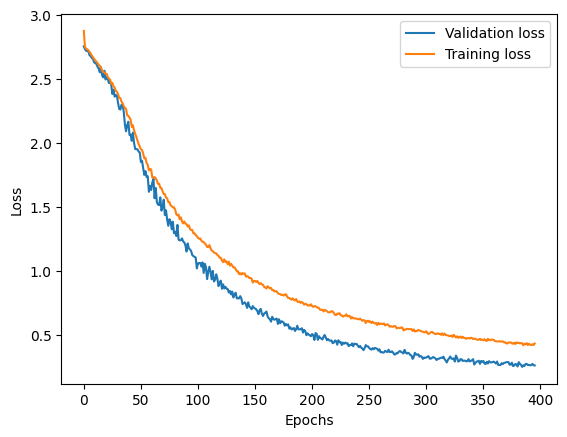

In [35]:
plt.plot(history.epoch ,history.history['val_loss'], label='Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.style.use('default')
plt.legend()
plt.show()

# 2. Generate text

In [0]:
def generate_text(model, start_string, temperature, length):
  # 평가 단계 (학습된 모델을 사용하여 텍스트 생성)

  # 시작 문자열을 숫자로 변환(벡터화)
  try:
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
  except:
    print("protein이 아닌 문자열이 포함되었습니다.")
    return 0

  # 결과를 저장할 빈 문자열
  text_generated = []

  # 의외의 효과를 만드는 온도 상수 추가
  temperature = temperature

  # 여기에서 배치 크기 == 1
  model.reset_states()
  num = 0
  while num < length:
      predictions = model(input_eval)
      # 배치 차원 제거
      predictions = tf.squeeze(predictions, 0)

      # 범주형 분포를 사용하여 모델에서 리턴한 단어 예측
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()


      # 예측된 단어를 다음 입력으로 모델에 전달
      # 이전 은닉 상태와 함께
      input_eval = tf.expand_dims([predicted_id], 0)
      # print(idx2char[predicted_id])
      text_generated.append(idx2char[predicted_id])
      
      # 추가부분 : \n을 만나면 break
      if predicted_id == 0:
        num = num + 1
      printProgress(num,length, 'Progress=', 'Completed', 1, 50)
  result = []
  temp = []
  for item in text_generated:
    temp.append(item)
    if item == '\n':
      result.append(''.join(temp))
      temp = []
  return result

In [0]:
def result_csv_generator(model, seed, temperature, file_name, length):
  result = []
  temp = generate_text(model, seed, temperature, length)
  csv = open('result_{}.csv'.format(file_name), 'w')
  i = 0
  for item in temp:
    csv.write('>{}\n'.format(i))
    i = i + 1
    csv.write('{}'.format(item))

  csv.close()

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, 1, file_name)
model.load_weights('/content/bestmodel/Model_{}'.format(file_name))
model.build(tf.TensorShape([1, None]))

In [39]:
result_csv_generator(model, "FAL", 0.1, file_name, 1000)

Progress= |##################################################| 100.0% Completed


# 3. Validate AMP activity

In [0]:
df = pd.read_csv('/content/LSTM_peptides/training_sequences_noC.csv', header=None)
training_prop = open('training_prop.csv', 'w')

i = 0
for item in df[0]:
  training_prop.write('>{}\n'.format(i))
  training_prop.write(item)
  training_prop.write('\n')
  i = i + 1

In [44]:
ratio = [i*0 for i in range(20)]
for item in text:
  ratio[char2idx[item]] = ratio[char2idx[item]] + 1

total_length = sum([i for i in ratio])
ratio = [i/total_length for i in ratio]
prob = [sum(ratio[:i+1]) for i in range(20)]
idx2char_list = idx2char.tolist()
random_num = 1000
random_seq = []
latter = 'A'
while len(random_seq) < random_num:
  temp = ''
  latter = 'A'
  while latter != '\n':
    latter = idx2char_list[np.random.choice(20, 1, p=ratio).tolist()[0]][0]
    temp = temp + latter
  
  if temp != '\n':
    random_seq.append(temp)
  printProgress(len(random_seq),random_num, 'Progress=', 'Completed', 1, 50)

Progress= |##################################################| 100.0% Completed


In [0]:
f = open('random.csv', 'w')
i = 0
for item in random_seq:
  f.write('>{}\n'.format(i))
  f.write(item)
  i = i + 1
f.close()

In [0]:
upload = files.upload()

In [0]:
From_GoogleDrive = True #@param {type:"boolean"}

if From_GoogleDrive == False:
  trainingset_prop = pd.read_csv('/content/training.csv')
  result_prop = pd.read_csv('/content/result.csv')
  random_prop = pd.read_csv('/content/random.csv')

else:
  trainingset_prop = pd.read_csv('/content/drive/My Drive/training.csv')
  result_prop = pd.read_csv('/content/drive/My Drive/result.csv')
  random_prop = pd.read_csv('/content/drive/My Drive/random.csv')

In [0]:
p_train2result = scipy.stats.ttest_ind(trainingset_prop['prob'], result_prop['prob'], equal_var=False).pvalue
p_result2random = scipy.stats.ttest_ind(result_prop['prob'], random_prop['prob'], equal_var=False).pvalue

In [48]:
print("=============== P value for Welch's T-test ===============\n")
print("between training set and result = ", p_train2result)
print("between random set and result = ", p_result2random)

=============== P value for Welch's T-test ===============

between training set and result =  0.0002281317243468403
between random set and result =  1.3534828801544558e-143


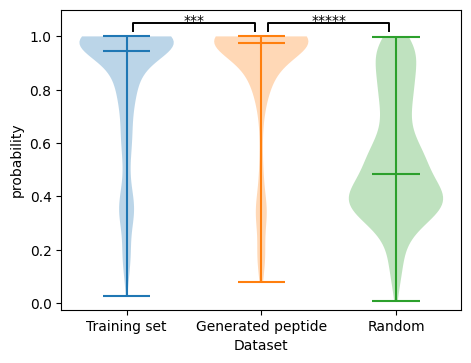

In [49]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_axes([0,0,1,1])
plt.ylim((-0.025,1.1))
plt.xticks([1,2,3],['Training set','Generated peptide', 'Random'])
plt.ylabel("probability")
plt.xlabel("Dataset")
plt.style.use(['default'])
bp1 = ax.violinplot(trainingset_prop['prob'], [1], widths=0.7, showmedians=True)
bp2 = ax.violinplot(result_prop['prob'], [2], widths=0.7, showmedians=True)
bp3 = ax.violinplot(random_prop['prob'], [3], widths=0.7, showmedians=True)


plt.plot([1.05, 1.05, 1.95, 1.95], [1.02, 1.05, 1.05, 1.02], lw=1.4, c='k')
ax.text(1.5, 1.06, "***",
       horizontalalignment='center',
       verticalalignment='center')

plt.plot([2.05, 2.05, 2.95, 2.95], [1.02, 1.05, 1.05, 1.02], lw=1.4, c='k')
ax.text(2.5, 1.06, "*****",
       horizontalalignment='center',
       verticalalignment='center')
fig.show()

<img src="https://pubs.acs.org/na101/home/literatum/publisher/achs/journals/content/jcisd8/2018/jcisd8.2018.58.issue-2/acs.jcim.7b00414/20180220/images/medium/ci-2017-00414w_0006.gif">